# Introduction

In this notebook, we will tune the hyperparameters in the models that performed best in our model exploration. We will use the training set restricted to **patients with no memory complaints** and measure the scores **without** cross-validation.

In [10]:
## Importing basic packages

## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import set_style

## This sets the plot style
## to have a grid on a white background
set_style("whitegrid")


## Importing the models, metrics, and learning tools
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, root_mean_squared_error, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

In [4]:
## Installing Optuna
!pip install optuna

In [7]:
import optuna

### Loading the data

In [11]:
## Reading the traning and testing datasets
df_train = pd.read_csv("../../data/train_set.csv")
df_test = pd.read_csv("../../data/validation_set.csv")

## Dropping redundant columns
df_train = df_train.drop(columns = ['DoctorInCharge' , 'PatientID' ])
df_test = df_test.drop(columns = ['DoctorInCharge' , 'PatientID' ])

## Restricting to patients with NoMemoryComplaints
df_train = df_train.loc[df_train.MemoryComplaints == 0]
df_test = df_test.loc[df_test.MemoryComplaints == 0]

df_train.head()

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,67,0,1,2,29.726811,1,15.642599,4.605988,7.871526,7.915239,...,6.088453,1,0,9.105791,0,0,0,0,0,0
1,76,1,1,2,36.169103,1,11.030414,9.534553,7.254090,4.364895,...,5.399515,1,0,4.725688,0,0,0,0,1,1
2,81,0,1,0,22.923111,0,9.314832,8.917378,3.807813,9.241849,...,4.594907,0,1,8.681801,0,0,0,0,0,1
3,90,0,1,3,31.430904,0,0.996496,7.108725,5.328610,4.977538,...,0.880355,0,0,7.805410,0,0,0,0,0,0
4,89,0,1,3,39.570099,0,1.576700,5.712014,1.026138,4.670244,...,0.293490,0,0,1.307295,0,0,0,0,1,1


In [11]:
## Seperating features into subcategories

all_features = ['Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI',
               'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
               'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease',
               'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP',
               'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL',
               'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment',
               'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion',
               'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks',
               'Forgetfulness' , 'Diagnosis']
demo_features = ['Age', 'Gender', 'Ethnicity','EducationLevel','Diagnosis']
life_style_features = ['BMI','Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality','Diagnosis']
medic_hist_features = ['FamilyHistoryAlzheimers', 'CardiovascularDisease','Diabetes', 'Depression', 'HeadInjury', 'Hypertension','Diagnosis']
clinical_features = ['SystolicBP','DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL','CholesterolTriglycerides','Diagnosis']
cognitive_features = ['MMSE', 'FunctionalAssessment','MemoryComplaints', 'BehavioralProblems', 'ADL','Diagnosis']
symptoms_features = ['Confusion','Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks','Forgetfulness','Diagnosis']

no_cognitive = [item for item in all_features if item not in cognitive_features]
no_cognitive.append('Diagnosis')

subcategory_dict = {'all_features' : all_features,'demo':demo_features ,'lifestyle': life_style_features , 'medic' : medic_hist_features , 
                    'clinical':clinical_features , 'cognitive': cognitive_features , 'symptoms': symptoms_features , 'no_cognitive': no_cognitive}


## Tuning **AdaBoost** On the Entire Dataset

We will be using **AdaBoost** as an ensemble and the **DecisionTreeClassifier** as its weak learner. 

The parameters tuned in **AdaBoost** will be
- `n_estimators`
- `learning_rate`
- `algorithm`
  
The parameters tuned in **DecisionTreeClassifier** will be
- `criterion`
- `max_depth`
- `min_sample_split`

### Optimizing `accuracy` score

In [26]:
## Defining an objective function for each Trial object; Trial is an object passed by Optuna to suggest, record, and manage hyperparameters in a trial.
def objective(trial):
    # Specifying parameters in the ensemble model that we want to tune
    ada_params= {
                'n_estimators': trial.suggest_int('n_estimators',50,200), # suggest_int is a method for the Trial object in Optuna
                'learning_rate': trial.suggest_float('learning_rate',0.1,1),
                'algorithm': trial.suggest_categorical('algorithm',['SAMME','SAMME.R'])
                }
    # Specifying parameters in the weak learner that we want to tune
    tree_params= {
                 'criterion': trial.suggest_categorical('criterion',['gini','entropy']),
                 'max_depth': trial.suggest_int('max_depth',1,4),
                 'min_samples_split': trial.suggest_int("min_samples_split", 2, 20)
                 }

    # Creating the model
    model = AdaBoostClassifier(**ada_params,estimator= DecisionTreeClassifier(**tree_params, random_state=123),random_state=123)

    # Fitting the model on the entire training set
    model.fit(df_train[all_features[:-1]],df_train.Diagnosis)

    # Predicting the target variable on the test set
    preds = model.predict(df_test[all_features[:-1]])
    score = accuracy_score(preds,df_test.Diagnosis)
    return score

## Creating a Study object in Optuna with the aim of maximizing the corresponding score
study_1 = optuna.create_study(direction = 'maximize')

## Running the study on the defined objective for a given number of trials
study_1.optimize(objective,n_trials=100)

print("best score: ", study_1.best_value)
print("best params ", study_1.best_params)

[I 2025-04-12 18:58:19,489] A new study created in memory with name: no-name-93963dbc-b26a-46c8-96f3-04d351a3685a
C:\Users\banih\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-04-12 18:58:23,248] Trial 0 finished with value: 0.9010989010989011 and parameters: {'n_estimators': 141, 'learning_rate': 0.5590337046290434, 'algorithm': 'SAMME.R', 'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 6}. Best is trial 0 with value: 0.9010989010989011.
C:\Users\banih\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-04-12 18:58:25,199] Trial 1 finished with value: 0.9267399267399268 and parameters: {'n_estimators': 110, 'learning_rate': 0.1

best score:  0.9597069597069597
best params  {'n_estimators': 155, 'learning_rate': 0.10565064269531074, 'algorithm': 'SAMME', 'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 8}


In [28]:
model_1_tree_params = {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 8}
model_1_ada_params = {'n_estimators': 155, 'learning_rate': 0.10565064269531074, 'algorithm': 'SAMME'}
model_1 = AdaBoostClassifier(**model_1_ada_params,estimator=DecisionTreeClassifier(**model_1_tree_params, random_state=123),random_state=123)

model_1.fit(df_train[all_features[:-1]],df_train.Diagnosis)
preds_1 = model_1.predict(df_test[all_features[:-1]])

metrics_1 = [accuracy_score(preds_1,df_test.Diagnosis), 
             precision_score(preds_1,df_test.Diagnosis), 
             recall_score(preds_1,df_test.Diagnosis), 
             f1_score(preds_1,df_test.Diagnosis)]
model_1_scores = pd.DataFrame({'all_features': metrics_1})
model_1_scores.index = ['Accuracy Score', 'Precision Score' , 'Recall Score', 'F1 Score']
model_1_scores

,all_features
Accuracy Score,0.959707
Precision Score,0.896104
Recall Score,0.958333
F1 Score,0.926174


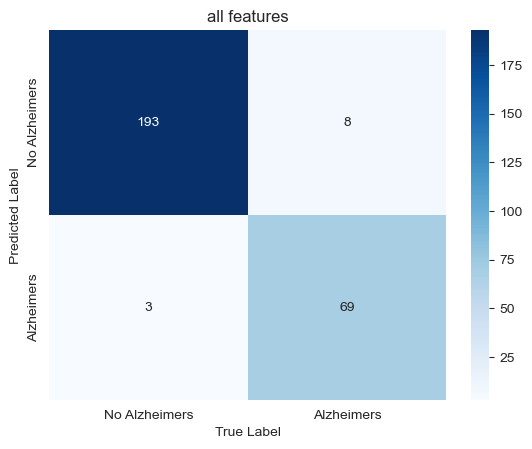

In [32]:
## Confusion matrix
sns.heatmap(confusion_matrix(preds_1,df_test.Diagnosis), annot=True, fmt="d", cmap="Blues", xticklabels=['No Alzheimers', 'Alzheimers'], yticklabels=['No Alzheimers', 'Alzheimers'])
plt.gca().set_title('all features')
plt.ylabel("Predicted Label")
plt.xlabel("True Label")
plt.show()

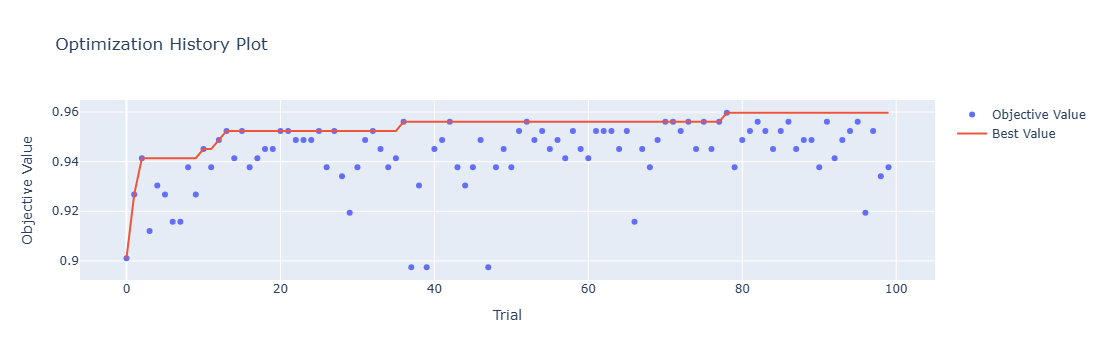

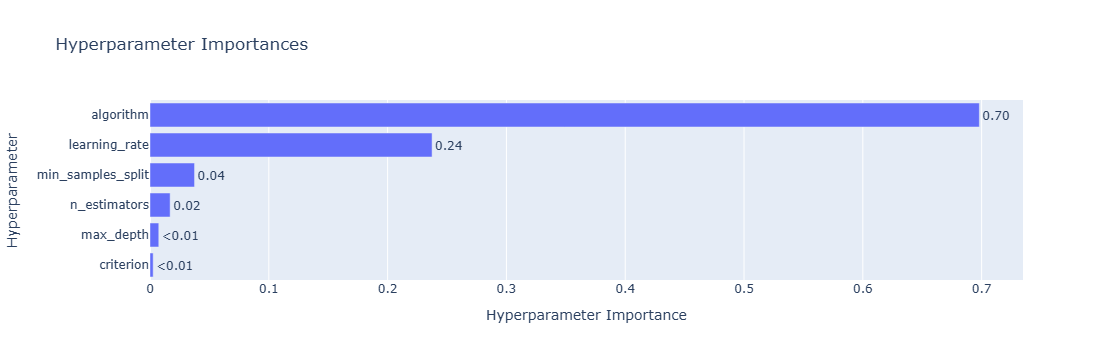

In [30]:
optuna.visualization.plot_optimization_history(study_1).show()
optuna.visualization.plot_param_importances(study_1).show()

### Optimizing `f1` score

In order to decrease the number of false negatives, we try to optimize the hyperparameters using other metrics that are more sensitive to the number of false negatives, namely `f1` score which is useful as a balanced metric for the cases when we have class imbalance.  

In [34]:
## Defining an objective function for each Trial object; Trial is an object passed by Optuna to suggest, record, and manage hyperparameters in a trial.
def objective(trial):
    # Specifying parameters in the ensemble model that we want to tune
    ada_params= {
                'n_estimators': trial.suggest_int('n_estimators',50,200), # suggest_int is a method for the Trial object in Optuna
                'learning_rate': trial.suggest_float('learning_rate',0.1,1),
                'algorithm': trial.suggest_categorical('algorithm',['SAMME','SAMME.R'])
                }
    # Specifying parameters in the weak learner that we want to tune
    tree_params= {
                 'criterion': trial.suggest_categorical('criterion',['gini','entropy']),
                 'max_depth': trial.suggest_int('max_depth',1,4),
                 'min_samples_split': trial.suggest_int("min_samples_split", 2, 20)
                 }

    # Creating the model
    model = AdaBoostClassifier(**ada_params,estimator= DecisionTreeClassifier(**tree_params, random_state=123),random_state=123)

    # Fitting the model on the entire training set
    model.fit(df_train[all_features[:-1]],df_train.Diagnosis)

    # Predicting the target variable on the test set
    preds = model.predict(df_test[all_features[:-1]])
    score = f1_score(preds,df_test.Diagnosis)
    return score

## Creating a Study object in Optuna with the aim of maximizing the corresponding score
study_2 = optuna.create_study(direction = 'maximize')

## Running the study on the defined objective for a given number of trials
study_2.optimize(objective,n_trials=100)

print("best score: ", study_2.best_value)
print("best params ", study_2.best_params)

[I 2025-04-12 19:09:31,565] A new study created in memory with name: no-name-fccad2b7-d90b-47c7-81ce-ce3ff2f5088f
[I 2025-04-12 19:09:34,921] Trial 0 finished with value: 0.8904109589041096 and parameters: {'n_estimators': 130, 'learning_rate': 0.6883207937197929, 'algorithm': 'SAMME', 'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 15}. Best is trial 0 with value: 0.8904109589041096.
[I 2025-04-12 19:09:37,501] Trial 1 finished with value: 0.8904109589041096 and parameters: {'n_estimators': 154, 'learning_rate': 0.8866030688971378, 'algorithm': 'SAMME', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 17}. Best is trial 0 with value: 0.8904109589041096.
C:\Users\banih\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-04-12 19:09:40,898] Trial 2 finished with value: 0.8201438848920863 and 

best score:  0.9261744966442953
best params  {'n_estimators': 167, 'learning_rate': 0.10697049944271753, 'algorithm': 'SAMME', 'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 18}


In [36]:
model_2_tree_params = {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 18}
model_2_ada_params = {'n_estimators': 167, 'learning_rate': 0.10697049944271753, 'algorithm': 'SAMME'}
model_2 = AdaBoostClassifier(**model_2_ada_params,estimator=DecisionTreeClassifier(**model_2_tree_params, random_state=123),random_state=123)

model_2.fit(df_train[all_features[:-1]],df_train.Diagnosis)
preds_2 = model_2.predict(df_test[all_features[:-1]])

metrics_2 = [accuracy_score(preds_2,df_test.Diagnosis), 
             precision_score(preds_2,df_test.Diagnosis), 
             recall_score(preds_2,df_test.Diagnosis), 
             f1_score(preds_2,df_test.Diagnosis)]
model_2_scores = pd.DataFrame({'all_features': metrics_2})
model_2_scores.index = ['Accuracy Score', 'Precision Score' , 'Recall Score', 'F1 Score']
model_2_scores

,all_features
Accuracy Score,0.959707
Precision Score,0.896104
Recall Score,0.958333
F1 Score,0.926174


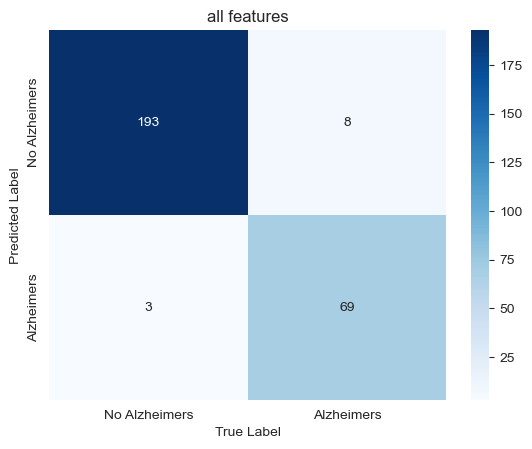

In [38]:
## Confusion matrix
sns.heatmap(confusion_matrix(preds_2,df_test.Diagnosis), annot=True, fmt="d", cmap="Blues", xticklabels=['No Alzheimers', 'Alzheimers'], yticklabels=['No Alzheimers', 'Alzheimers'])
plt.gca().set_title('all features')
plt.ylabel("Predicted Label")
plt.xlabel("True Label")
plt.show()

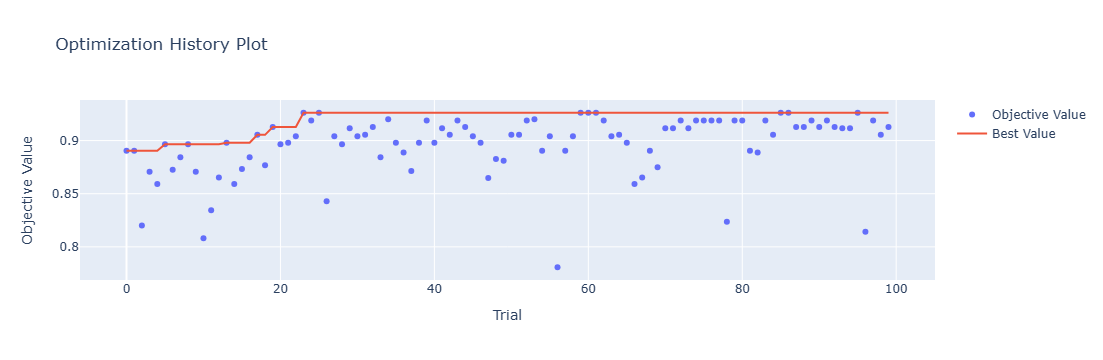

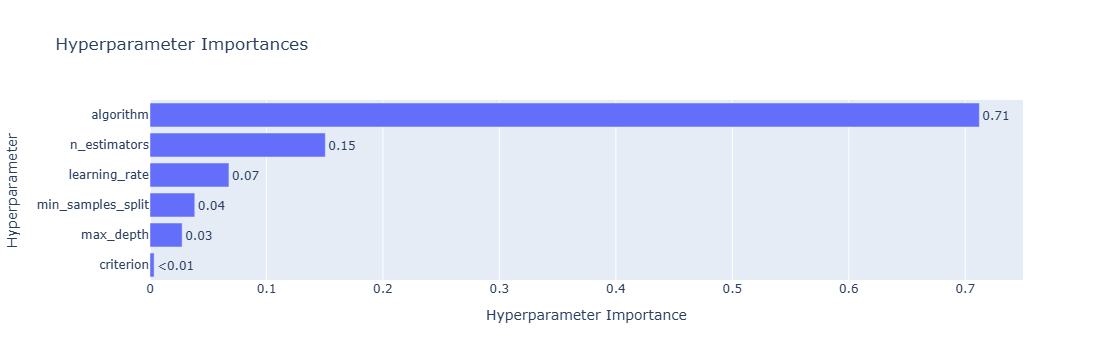

In [40]:
optuna.visualization.plot_optimization_history(study_2).show()
optuna.visualization.plot_param_importances(study_2).show()

### Optimizing `recall` score

We try to optimize `recall` score.

In [42]:
## Defining an objective function for each Trial object; Trial is an object passed by Optuna to suggest, record, and manage hyperparameters in a trial.
def objective(trial):
    # Specifying parameters in the ensemble model that we want to tune
    ada_params= {
                'n_estimators': trial.suggest_int('n_estimators',50,200), # suggest_int is a method for the Trial object in Optuna
                'learning_rate': trial.suggest_float('learning_rate',0.1,1),
                'algorithm': trial.suggest_categorical('algorithm',['SAMME','SAMME.R'])
                }
    # Specifying parameters in the weak learner that we want to tune
    tree_params= {
                 'criterion': trial.suggest_categorical('criterion',['gini','entropy']),
                 'max_depth': trial.suggest_int('max_depth',1,4),
                 'min_samples_split': trial.suggest_int("min_samples_split", 2, 20)
                 }

    # Creating the model
    model = AdaBoostClassifier(**ada_params,estimator= DecisionTreeClassifier(**tree_params, random_state=123),random_state=123)

    # Fitting the model on the entire training set
    model.fit(df_train[all_features[:-1]],df_train.Diagnosis)

    # Predicting the target variable on the test set
    preds = model.predict(df_test[all_features[:-1]])
    score = recall_score(preds,df_test.Diagnosis)
    return score

## Creating a Study object in Optuna with the aim of maximizing the corresponding score
study_3 = optuna.create_study(direction = 'maximize')

## Running the study on the defined objective for a given number of trials
study_3.optimize(objective,n_trials=100)

print("best score: ", study_3.best_value)
print("best params ", study_3.best_params)

[I 2025-04-12 19:16:47,726] A new study created in memory with name: no-name-6bbec554-cbb8-4d4c-942e-9c5ae01e449c
C:\Users\banih\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-04-12 19:16:50,488] Trial 0 finished with value: 0.9393939393939394 and parameters: {'n_estimators': 141, 'learning_rate': 0.2373316192181129, 'algorithm': 'SAMME.R', 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 17}. Best is trial 0 with value: 0.9393939393939394.
[I 2025-04-12 19:16:52,561] Trial 1 finished with value: 0.9705882352941176 and parameters: {'n_estimators': 94, 'learning_rate': 0.19500768267650814, 'algorithm': 'SAMME', 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 10}. Best is trial 1 with value: 0.9705882352941176.
[I 2025-04-12 19:16:53,534] Trial 2 finished with value: 0.8888888888888888 and para

best score:  0.9705882352941176
best params  {'n_estimators': 94, 'learning_rate': 0.19500768267650814, 'algorithm': 'SAMME', 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 10}


In [44]:
model_3_tree_params = {'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 10}
model_3_ada_params = {'n_estimators': 94, 'learning_rate': 0.19500768267650814, 'algorithm': 'SAMME'}
model_3 = AdaBoostClassifier(**model_3_ada_params,estimator=DecisionTreeClassifier(**model_3_tree_params, random_state=123),random_state=123)

model_3.fit(df_train[all_features[:-1]],df_train.Diagnosis)
preds_3 = model_3.predict(df_test[all_features[:-1]])

metrics_3 = [accuracy_score(preds_3,df_test.Diagnosis), 
             precision_score(preds_3,df_test.Diagnosis), 
             recall_score(preds_3,df_test.Diagnosis), 
             f1_score(preds_3,df_test.Diagnosis)]
model_3_scores = pd.DataFrame({'all_features': metrics_3})
model_3_scores.index = ['Accuracy Score', 'Precision Score' , 'Recall Score', 'F1 Score']
model_3_scores

,all_features
Accuracy Score,0.952381
Precision Score,0.857143
Recall Score,0.970588
F1 Score,0.910345


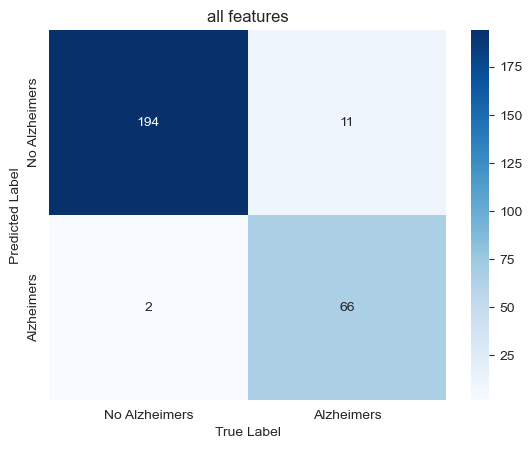

In [46]:
## Confusion matrix
sns.heatmap(confusion_matrix(preds_3,df_test.Diagnosis), annot=True, fmt="d", cmap="Blues", xticklabels=['No Alzheimers', 'Alzheimers'], yticklabels=['No Alzheimers', 'Alzheimers'])
plt.gca().set_title('all features')
plt.ylabel("Predicted Label")
plt.xlabel("True Label")
plt.show()

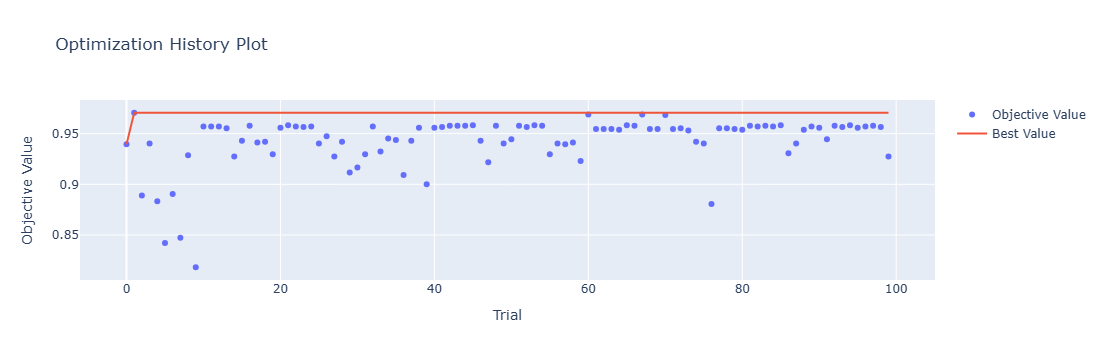

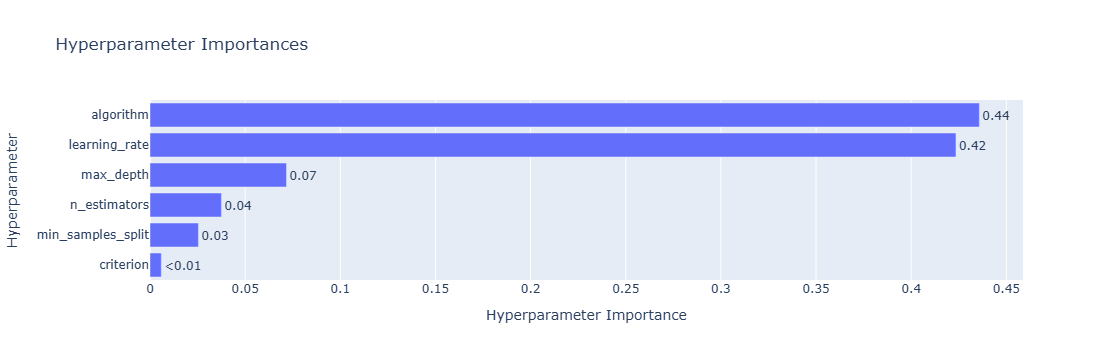

In [48]:
optuna.visualization.plot_optimization_history(study_3).show()
optuna.visualization.plot_param_importances(study_3).show()

### Optimizing `precision` score

We try to optimize `precision` score.

In [50]:
## Defining an objective function for each Trial object; Trial is an object passed by Optuna to suggest, record, and manage hyperparameters in a trial.
def objective(trial):
    # Specifying parameters in the ensemble model that we want to tune
    ada_params= {
                'n_estimators': trial.suggest_int('n_estimators',50,200), # suggest_int is a method for the Trial object in Optuna
                'learning_rate': trial.suggest_float('learning_rate',0.1,1),
                'algorithm': trial.suggest_categorical('algorithm',['SAMME','SAMME.R'])
                }
    # Specifying parameters in the weak learner that we want to tune
    tree_params= {
                 'criterion': trial.suggest_categorical('criterion',['gini','entropy']),
                 'max_depth': trial.suggest_int('max_depth',1,4),
                 'min_samples_split': trial.suggest_int("min_samples_split", 2, 20)
                 }

    # Creating the model
    model = AdaBoostClassifier(**ada_params,estimator= DecisionTreeClassifier(**tree_params, random_state=123),random_state=123)

    # Fitting the model on the entire training set
    model.fit(df_train[all_features[:-1]],df_train.Diagnosis)

    # Predicting the target variable on the test set
    preds = model.predict(df_test[all_features[:-1]])
    score = precision_score(preds,df_test.Diagnosis)
    return score

## Creating a Study object in Optuna with the aim of maximizing the corresponding score
study_4 = optuna.create_study(direction = 'maximize')

## Running the study on the defined objective for a given number of trials
study_4.optimize(objective,n_trials=100)

print("best score: ", study_4.best_value)
print("best params ", study_4.best_params)

[I 2025-04-12 19:23:05,012] A new study created in memory with name: no-name-11e0e8c0-849e-41bc-9974-7a5a3e6cd818
C:\Users\banih\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

[I 2025-04-12 19:23:07,121] Trial 0 finished with value: 0.7012987012987013 and parameters: {'n_estimators': 138, 'learning_rate': 0.9983272660608764, 'algorithm': 'SAMME.R', 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 18}. Best is trial 0 with value: 0.7012987012987013.
[I 2025-04-12 19:23:09,427] Trial 1 finished with value: 0.8701298701298701 and parameters: {'n_estimators': 106, 'learning_rate': 0.10132357151006885, 'algorithm': 'SAMME', 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 3}. Best is trial 1 with value: 0.8701298701298701.
C:\Users\banih\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527:

best score:  0.8831168831168831
best params  {'n_estimators': 126, 'learning_rate': 0.27673046833804105, 'algorithm': 'SAMME', 'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5}


In [52]:
model_4_tree_params = {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5}
model_4_ada_params = {'n_estimators': 126, 'learning_rate': 0.27673046833804105, 'algorithm': 'SAMME'}
model_4 = AdaBoostClassifier(**model_4_ada_params,estimator=DecisionTreeClassifier(**model_4_tree_params, random_state=123),random_state=123)

model_4.fit(df_train[all_features[:-1]],df_train.Diagnosis)
preds_4 = model_4.predict(df_test[all_features[:-1]])

metrics_4 = [accuracy_score(preds_4,df_test.Diagnosis), 
             precision_score(preds_4,df_test.Diagnosis), 
             recall_score(preds_4,df_test.Diagnosis), 
             f1_score(preds_4,df_test.Diagnosis)]
model_4_scores = pd.DataFrame({'all_features': metrics_4})
model_4_scores.index = ['Accuracy Score', 'Precision Score' , 'Recall Score', 'F1 Score']
model_4_scores

,all_features
Accuracy Score,0.956044
Precision Score,0.883117
Recall Score,0.957746
F1 Score,0.918919


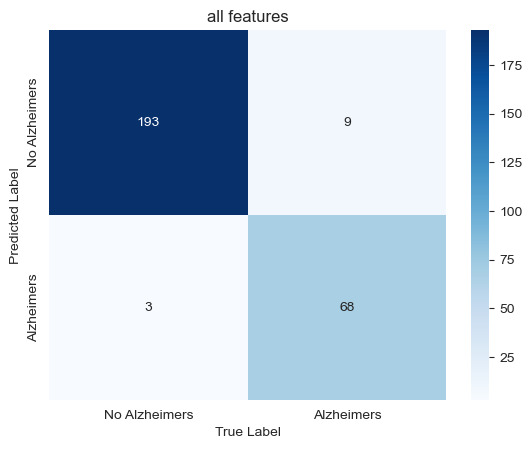

In [54]:
## Confusion matrix
sns.heatmap(confusion_matrix(preds_4,df_test.Diagnosis), annot=True, fmt="d", cmap="Blues", xticklabels=['No Alzheimers', 'Alzheimers'], yticklabels=['No Alzheimers', 'Alzheimers'])
plt.gca().set_title('all features')
plt.ylabel("Predicted Label")
plt.xlabel("True Label")
plt.show()

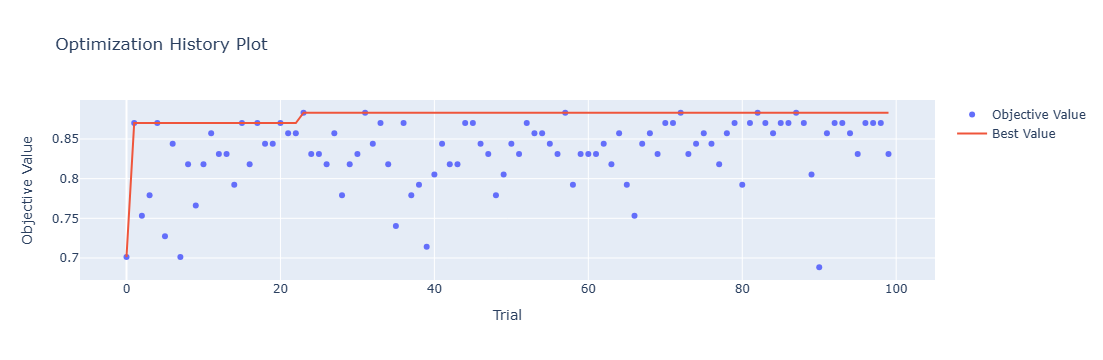

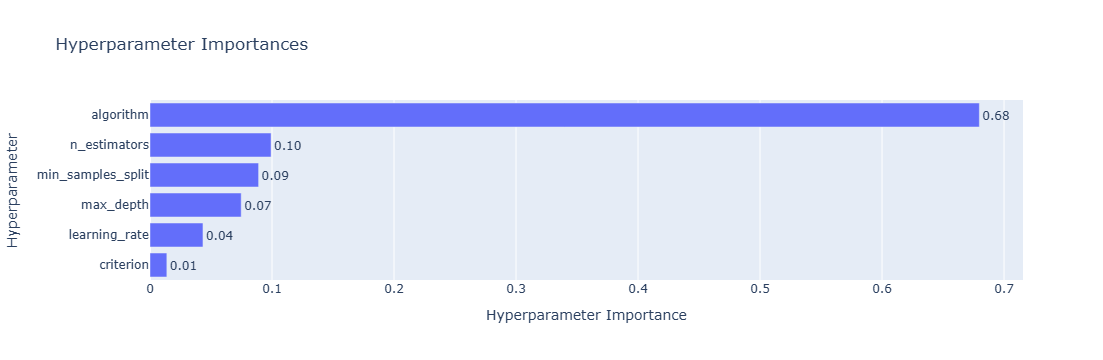

In [56]:
optuna.visualization.plot_optimization_history(study_4).show()
optuna.visualization.plot_param_importances(study_4).show()

## Summary of **AdaBoost** hyperparameter tuning

In [58]:
## Table of the metrics for each tuned model
ada_metrics_df = pd.DataFrame({'model_1': metrics_1 , 'model_2': metrics_2, 'model_3': metrics_3, 'model_4': metrics_4})
ada_metrics_df.index = ['Accuracy Score', 'Precision Score' , 'Recall Score', 'F1 Score']
ada_metrics_df

,model_1,model_2,model_3,model_4
Accuracy Score,0.959707,0.959707,0.952381,0.956044
Precision Score,0.896104,0.896104,0.857143,0.883117
Recall Score,0.958333,0.958333,0.970588,0.957746
F1 Score,0.926174,0.926174,0.910345,0.918919


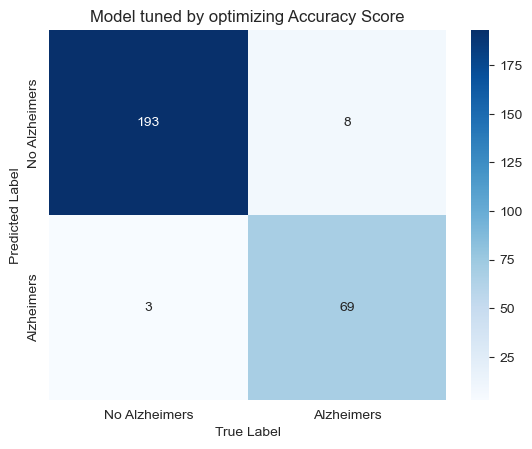

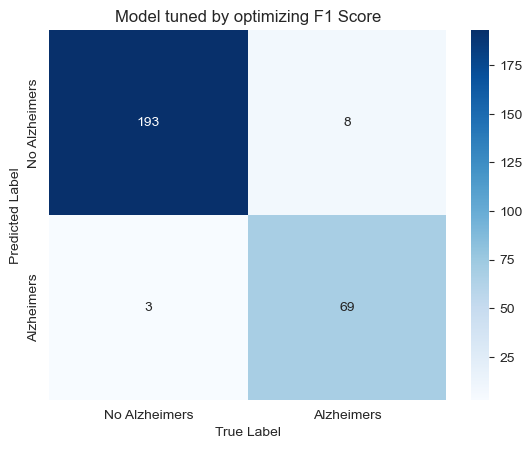

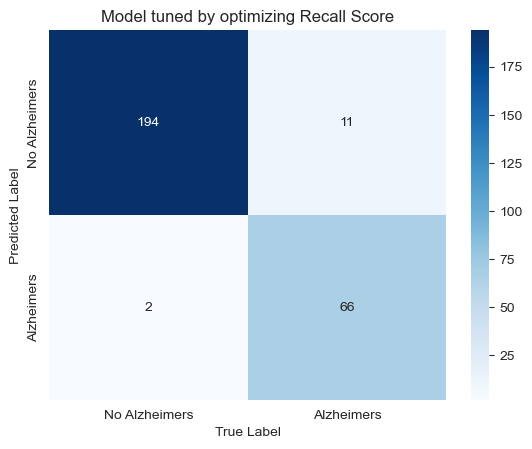

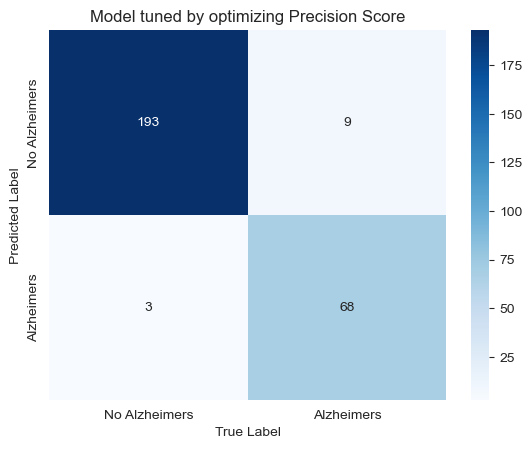

In [60]:
## Confusion matrices for each model
metric_labels = ['Accuracy Score', 'F1 Score' , 'Recall Score', 'Precision Score']
preds = [preds_1, preds_2, preds_3, preds_4]
for i in range(len(preds)):
    sns.heatmap(confusion_matrix(preds[i],df_test.Diagnosis), annot=True, fmt="d", cmap="Blues", xticklabels=['No Alzheimers', 'Alzheimers'], yticklabels=['No Alzheimers', 'Alzheimers'])
    plt.gca().set_title('Model tuned by optimizing '+ metric_labels[i])
    plt.ylabel("Predicted Label")
    plt.xlabel("True Label")
    plt.show()
    

## Tuning **XGBoost** On the Entire Dataset

In [62]:
## Installing XGBoost
!pip install xgboost

In [64]:
## Importing model
import xgboost
from xgboost import XGBClassifier

We tune the following core parameters in the **XGBoost** classifier model:
- `n_estimators`
- `learning_rate`
- `max_depth`
- `min_child_weight`
- `gamma`
- `subsample`
- `colsample_bytree`
- `eval_metric`

Also, we tune the following regularization parameters:
- `reg_alpha`
- `reg_lambda`
- `scale_pos_weight`

### Optimizing `accuracy` score

In [66]:
## Defining an objective function for each Trial object; Trial is an object passed by Optuna to suggest, record, and manage hyperparameters in a trial.
def objective(trial):
    # Specifying parameters in the model that we want to tune
    params = {'n_estimators' : trial.suggest_int('n_estimators', 100,1000),
              'learning_rate' : trial.suggest_float('learning_rate',0.01, 0.3),
              'max_depth' : trial.suggest_int('max_depth', 3, 10),
              'min_child_weight' : trial.suggest_int('min_child_weight', 1,10),
              'gamma' : trial.suggest_int('gamma',0,5),
              'subsample' : trial.suggest_float('subsample', 0.5,1),
              'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.5,1),
              'reg_alpha' : trial.suggest_float('reg_alpha', 0,1),
              'reg_lambda' : trial.suggest_float('reg_lambda' , 0,1),
              'scale_pos_weight' : trial.suggest_int('scale_pos_weight',1,100),
              'eval_metric' : trial.suggest_categorical('eval_metric', ['logloss', 'error', 'auc'])
              }

    
    # Creating the model
    model = XGBClassifier(**params,random_state=123)

    # Fitting the model on the entire training set
    model.fit(df_train[all_features[:-1]],df_train.Diagnosis)

    # Predicting the target variable on the test set
    preds = model.predict(df_test[all_features[:-1]])
    score = accuracy_score(preds,df_test.Diagnosis)
    return score

## Creating a Study object in Optuna with the aim of maximizing the corresponding score
study_5 = optuna.create_study(direction = 'maximize')

## Running the study on the defined objective for a given number of trials
study_5.optimize(objective,n_trials=100)

print("best score: ", study_5.best_value)
print("best params ", study_5.best_params)

[I 2025-04-12 19:29:40,964] A new study created in memory with name: no-name-1c8a12c6-ff3f-4df0-be22-3613d1327fb3
[I 2025-04-12 19:29:41,706] Trial 0 finished with value: 0.8901098901098901 and parameters: {'n_estimators': 758, 'learning_rate': 0.2531977632174918, 'max_depth': 3, 'min_child_weight': 7, 'gamma': 2, 'subsample': 0.6226003436454477, 'colsample_bytree': 0.8512086152477372, 'reg_alpha': 0.8490320217867631, 'reg_lambda': 0.45596990130617354, 'scale_pos_weight': 91, 'eval_metric': 'error'}. Best is trial 0 with value: 0.8901098901098901.
[I 2025-04-12 19:29:42,244] Trial 1 finished with value: 0.9413919413919414 and parameters: {'n_estimators': 757, 'learning_rate': 0.20372228052501898, 'max_depth': 5, 'min_child_weight': 10, 'gamma': 2, 'subsample': 0.88742604046981, 'colsample_bytree': 0.6017391110291951, 'reg_alpha': 0.7883360994455015, 'reg_lambda': 0.5775588932783007, 'scale_pos_weight': 12, 'eval_metric': 'logloss'}. Best is trial 1 with value: 0.9413919413919414.
[I 20

best score:  0.9560439560439561
best params  {'n_estimators': 465, 'learning_rate': 0.13805409556290948, 'max_depth': 6, 'min_child_weight': 10, 'gamma': 4, 'subsample': 0.9622422802286132, 'colsample_bytree': 0.5560988335717663, 'reg_alpha': 0.8988847251169385, 'reg_lambda': 0.5371494006640329, 'scale_pos_weight': 2, 'eval_metric': 'auc'}


In [68]:
model_5_params = {'n_estimators': 465, 'learning_rate': 0.13805409556290948, 'max_depth': 6, 'min_child_weight': 10, 'gamma': 4, 'subsample': 0.9622422802286132, 'colsample_bytree': 0.5560988335717663, 'reg_alpha': 0.8988847251169385, 'reg_lambda': 0.5371494006640329, 'scale_pos_weight': 2, 'eval_metric': 'auc'}
model_5 = XGBClassifier(**model_5_params,random_state=123)

model_5.fit(df_train[all_features[:-1]],df_train.Diagnosis)
preds_5 = model_5.predict(df_test[all_features[:-1]])

metrics_5 = [accuracy_score(preds_5,df_test.Diagnosis), 
             precision_score(preds_5,df_test.Diagnosis), 
             recall_score(preds_5,df_test.Diagnosis), 
             f1_score(preds_5,df_test.Diagnosis)]
model_5_scores = pd.DataFrame({'all_features': metrics_5})
model_5_scores.index = ['Accuracy Score', 'Precision Score' , 'Recall Score', 'F1 Score']
model_5_scores

,all_features
Accuracy Score,0.956044
Precision Score,0.896104
Recall Score,0.945205
F1 Score,0.920000


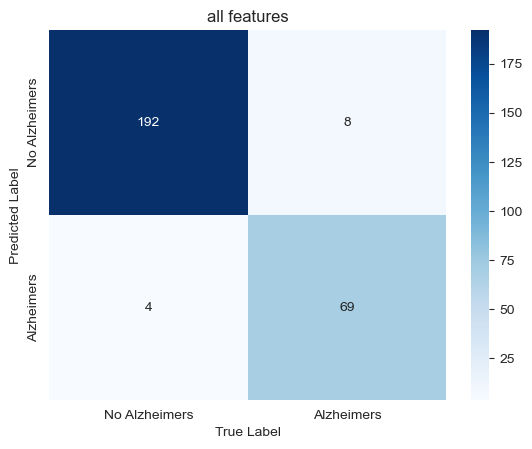

In [70]:
## Confusion matrix
sns.heatmap(confusion_matrix(preds_5,df_test.Diagnosis), annot=True, fmt="d", cmap="Blues", xticklabels=['No Alzheimers', 'Alzheimers'], yticklabels=['No Alzheimers', 'Alzheimers'])
plt.gca().set_title('all features')
plt.ylabel("Predicted Label")
plt.xlabel("True Label")
plt.show()

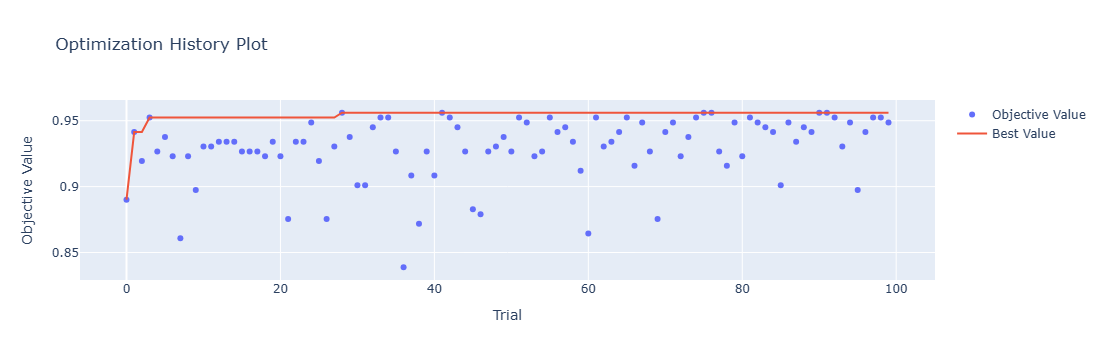

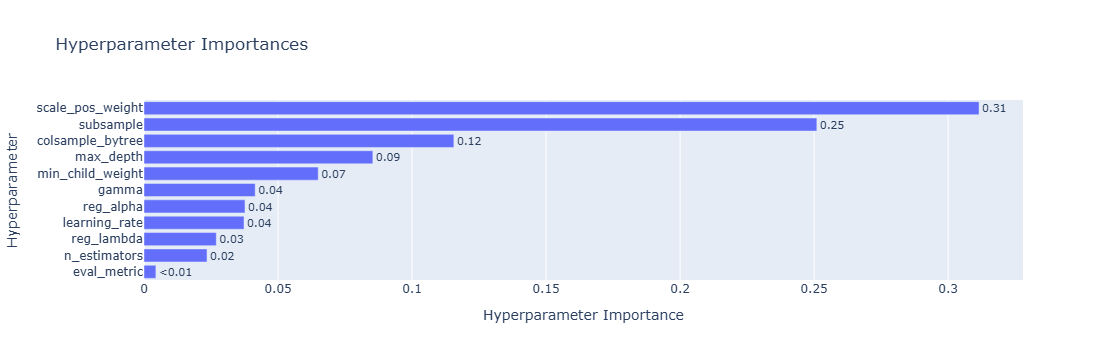

In [72]:
optuna.visualization.plot_optimization_history(study_5).show()
optuna.visualization.plot_param_importances(study_5).show()

### Optimizing `f1` score

In [74]:
## Defining an objective function for each Trial object; Trial is an object passed by Optuna to suggest, record, and manage hyperparameters in a trial.
def objective(trial):
    # Specifying parameters in the model that we want to tune
    params = {'n_estimators' : trial.suggest_int('n_estimators', 100,1000),
              'learning_rate' : trial.suggest_float('learning_rate',0.01, 0.3),
              'max_depth' : trial.suggest_int('max_depth', 3, 10),
              'min_child_weight' : trial.suggest_int('min_child_weight', 1,10),
              'gamma' : trial.suggest_int('gamma',0,5),
              'subsample' : trial.suggest_float('subsample', 0.5,1),
              'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.5,1),
              'reg_alpha' : trial.suggest_float('reg_alpha', 0,1),
              'reg_lambda' : trial.suggest_float('reg_lambda' , 0,1),
              'scale_pos_weight' : trial.suggest_int('scale_pos_weight',1,100),
              'eval_metric' : trial.suggest_categorical('eval_metric', ['logloss', 'error', 'auc'])
              }

    
    # Creating the model
    model = XGBClassifier(**params,random_state=123)

    # Fitting the model on the entire training set
    model.fit(df_train[all_features[:-1]],df_train.Diagnosis)

    # Predicting the target variable on the test set
    preds = model.predict(df_test[all_features[:-1]])
    score = f1_score(preds,df_test.Diagnosis)
    return score

## Creating a Study object in Optuna with the aim of maximizing the corresponding score
study_6 = optuna.create_study(direction = 'maximize')

## Running the study on the defined objective for a given number of trials
study_6.optimize(objective,n_trials=100)

print("best score: ", study_6.best_value)
print("best params ", study_6.best_params)

[I 2025-04-12 19:31:34,999] A new study created in memory with name: no-name-a48fd4a9-95bc-4f7b-9284-e400e2d5cf49
[I 2025-04-12 19:31:35,374] Trial 0 finished with value: 0.8588957055214724 and parameters: {'n_estimators': 334, 'learning_rate': 0.14368426267974888, 'max_depth': 9, 'min_child_weight': 6, 'gamma': 4, 'subsample': 0.8220631844547632, 'colsample_bytree': 0.6770088619316756, 'reg_alpha': 0.5080538106512569, 'reg_lambda': 0.1954545033927002, 'scale_pos_weight': 63, 'eval_metric': 'auc'}. Best is trial 0 with value: 0.8588957055214724.
[I 2025-04-12 19:31:36,092] Trial 1 finished with value: 0.8481012658227848 and parameters: {'n_estimators': 830, 'learning_rate': 0.23354750258412874, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 1, 'subsample': 0.5580901766514359, 'colsample_bytree': 0.7986442555034874, 'reg_alpha': 0.4664643303059466, 'reg_lambda': 0.7444399514860569, 'scale_pos_weight': 38, 'eval_metric': 'logloss'}. Best is trial 0 with value: 0.8588957055214724.
[I 202

best score:  0.9261744966442953
best params  {'n_estimators': 342, 'learning_rate': 0.2936557853809352, 'max_depth': 4, 'min_child_weight': 2, 'gamma': 3, 'subsample': 0.9505333790576483, 'colsample_bytree': 0.6024713590870578, 'reg_alpha': 0.22059934204998982, 'reg_lambda': 0.8737784998045829, 'scale_pos_weight': 1, 'eval_metric': 'error'}


In [76]:
model_6_params = {'n_estimators': 342, 'learning_rate': 0.2936557853809352, 'max_depth': 4, 'min_child_weight': 2, 'gamma': 3, 'subsample': 0.9505333790576483, 'colsample_bytree': 0.6024713590870578, 'reg_alpha': 0.22059934204998982, 'reg_lambda': 0.8737784998045829, 'scale_pos_weight': 1, 'eval_metric': 'error'}
model_6 = XGBClassifier(**model_6_params,random_state=123)

model_6.fit(df_train[all_features[:-1]],df_train.Diagnosis)
preds_6 = model_6.predict(df_test[all_features[:-1]])

metrics_6 = [accuracy_score(preds_6,df_test.Diagnosis), 
             precision_score(preds_6,df_test.Diagnosis), 
             recall_score(preds_6,df_test.Diagnosis), 
             f1_score(preds_6,df_test.Diagnosis)]
model_6_scores = pd.DataFrame({'all_features': metrics_6})
model_6_scores.index = ['Accuracy Score', 'Precision Score' , 'Recall Score', 'F1 Score']
model_6_scores

,all_features
Accuracy Score,0.959707
Precision Score,0.896104
Recall Score,0.958333
F1 Score,0.926174


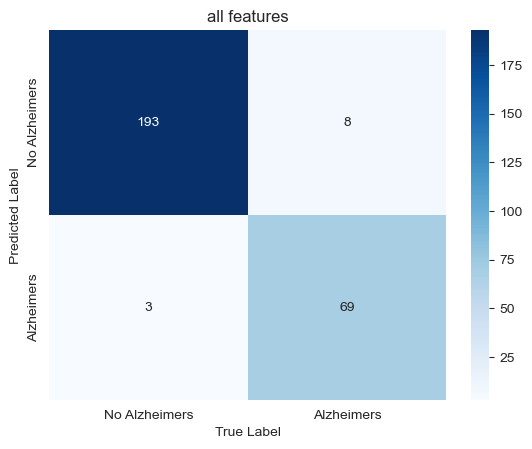

In [78]:
## Confusion matrix
sns.heatmap(confusion_matrix(preds_6,df_test.Diagnosis), annot=True, fmt="d", cmap="Blues", xticklabels=['No Alzheimers', 'Alzheimers'], yticklabels=['No Alzheimers', 'Alzheimers'])
plt.gca().set_title('all features')
plt.ylabel("Predicted Label")
plt.xlabel("True Label")
plt.show()

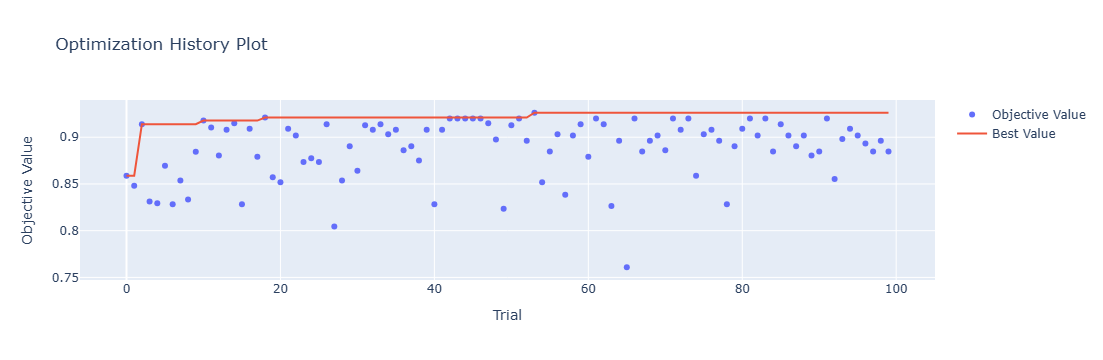

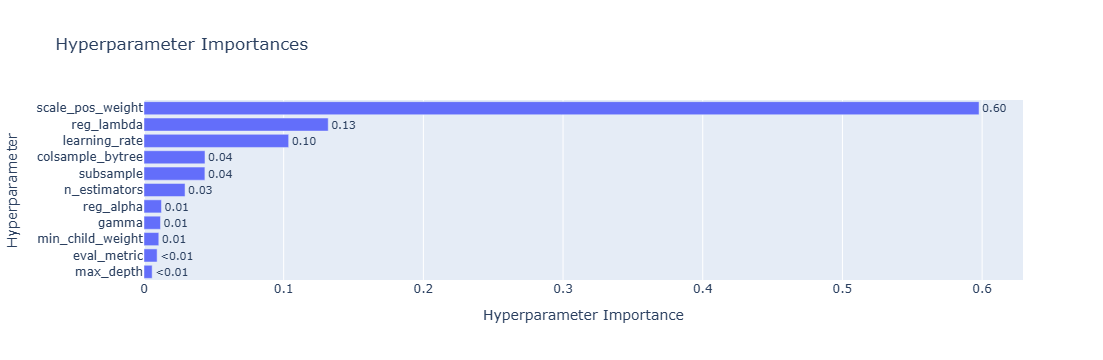

In [80]:
optuna.visualization.plot_optimization_history(study_6).show()
optuna.visualization.plot_param_importances(study_6).show()

### Optimizing `recall` score

In [82]:
## Defining an objective function for each Trial object; Trial is an object passed by Optuna to suggest, record, and manage hyperparameters in a trial.
def objective(trial):
    # Specifying parameters in the model that we want to tune
    params = {'n_estimators' : trial.suggest_int('n_estimators', 100,1000),
              'learning_rate' : trial.suggest_float('learning_rate',0.01, 0.3),
              'max_depth' : trial.suggest_int('max_depth', 3, 10),
              'min_child_weight' : trial.suggest_int('min_child_weight', 1,10),
              'gamma' : trial.suggest_int('gamma',0,5),
              'subsample' : trial.suggest_float('subsample', 0.5,1),
              'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.5,1),
              'reg_alpha' : trial.suggest_float('reg_alpha', 0,1),
              'reg_lambda' : trial.suggest_float('reg_lambda' , 0,1),
              'scale_pos_weight' : trial.suggest_int('scale_pos_weight',1,100),
              'eval_metric' : trial.suggest_categorical('eval_metric', ['logloss', 'error', 'auc'])
              }

    
    # Creating the model
    model = XGBClassifier(**params,random_state=123)

    # Fitting the model on the entire training set
    model.fit(df_train[all_features[:-1]],df_train.Diagnosis)

    # Predicting the target variable on the test set
    preds = model.predict(df_test[all_features[:-1]])
    score = recall_score(preds,df_test.Diagnosis)
    return score

## Creating a Study object in Optuna with the aim of maximizing the corresponding score
study_7 = optuna.create_study(direction = 'maximize')

## Running the study on the defined objective for a given number of trials
study_7.optimize(objective,n_trials=100)

print("best score: ", study_7.best_value)
print("best params ", study_7.best_params)

[I 2025-04-12 19:33:50,783] A new study created in memory with name: no-name-1ae8de3a-5ad5-4ff7-93a6-ec5384fc443b
[I 2025-04-12 19:33:51,456] Trial 0 finished with value: 0.7582417582417582 and parameters: {'n_estimators': 660, 'learning_rate': 0.25232381244580027, 'max_depth': 10, 'min_child_weight': 9, 'gamma': 2, 'subsample': 0.8695720623638828, 'colsample_bytree': 0.5699955978807966, 'reg_alpha': 0.2621659033834878, 'reg_lambda': 0.43915638158945547, 'scale_pos_weight': 66, 'eval_metric': 'auc'}. Best is trial 0 with value: 0.7582417582417582.
[I 2025-04-12 19:33:51,776] Trial 1 finished with value: 0.7368421052631579 and parameters: {'n_estimators': 352, 'learning_rate': 0.2728068273625442, 'max_depth': 5, 'min_child_weight': 8, 'gamma': 4, 'subsample': 0.8597242154086191, 'colsample_bytree': 0.6697977623246307, 'reg_alpha': 0.34082942743504685, 'reg_lambda': 0.812755677397666, 'scale_pos_weight': 90, 'eval_metric': 'auc'}. Best is trial 0 with value: 0.7582417582417582.
[I 2025-0

best score:  0.9452054794520548
best params  {'n_estimators': 766, 'learning_rate': 0.13584125712173994, 'max_depth': 6, 'min_child_weight': 2, 'gamma': 3, 'subsample': 0.6878330786988919, 'colsample_bytree': 0.5087336753618332, 'reg_alpha': 0.6370310065581517, 'reg_lambda': 0.5669256571095311, 'scale_pos_weight': 1, 'eval_metric': 'logloss'}


In [84]:
model_7_params = {'n_estimators': 766, 'learning_rate': 0.13584125712173994, 'max_depth': 6, 'min_child_weight': 2, 'gamma': 3, 'subsample': 0.6878330786988919, 'colsample_bytree': 0.5087336753618332, 'reg_alpha': 0.6370310065581517, 'reg_lambda': 0.5669256571095311, 'scale_pos_weight': 1, 'eval_metric': 'logloss'}
model_7 = XGBClassifier(**model_7_params,random_state=123)

model_7.fit(df_train[all_features[:-1]],df_train.Diagnosis)
preds_7 = model_7.predict(df_test[all_features[:-1]])

metrics_7 = [accuracy_score(preds_7,df_test.Diagnosis), 
             precision_score(preds_7,df_test.Diagnosis), 
             recall_score(preds_7,df_test.Diagnosis), 
             f1_score(preds_7,df_test.Diagnosis)]
model_7_scores = pd.DataFrame({'all_features': metrics_7})
model_7_scores.index = ['Accuracy Score', 'Precision Score' , 'Recall Score', 'F1 Score']
model_7_scores

,all_features
Accuracy Score,0.956044
Precision Score,0.896104
Recall Score,0.945205
F1 Score,0.920000


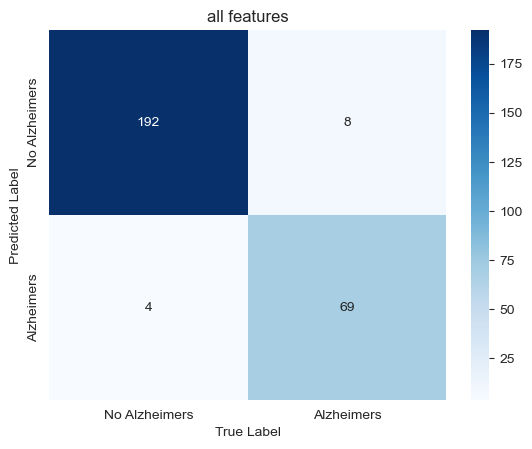

In [86]:
## Confusion matrix
sns.heatmap(confusion_matrix(preds_7,df_test.Diagnosis), annot=True, fmt="d", cmap="Blues", xticklabels=['No Alzheimers', 'Alzheimers'], yticklabels=['No Alzheimers', 'Alzheimers'])
plt.gca().set_title('all features')
plt.ylabel("Predicted Label")
plt.xlabel("True Label")
plt.show()

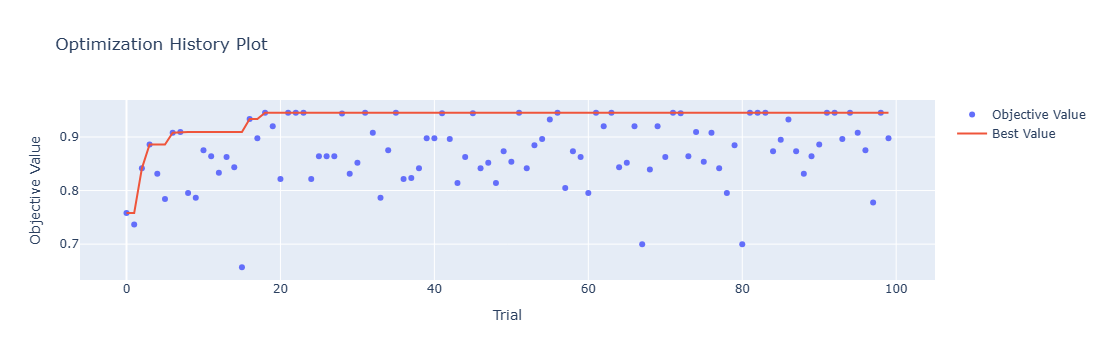

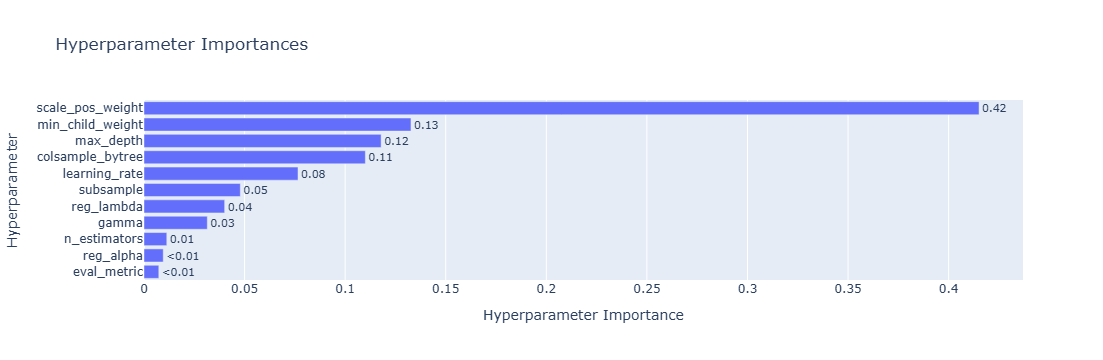

In [88]:
optuna.visualization.plot_optimization_history(study_7).show()
optuna.visualization.plot_param_importances(study_7).show()

### Optimizing `precision` score

In [90]:
## Defining an objective function for each Trial object; Trial is an object passed by Optuna to suggest, record, and manage hyperparameters in a trial.
def objective(trial):
    # Specifying parameters in the model that we want to tune
    params = {'n_estimators' : trial.suggest_int('n_estimators', 100,1000),
              'learning_rate' : trial.suggest_float('learning_rate',0.01, 0.3),
              'max_depth' : trial.suggest_int('max_depth', 3, 10),
              'min_child_weight' : trial.suggest_int('min_child_weight', 1,10),
              'gamma' : trial.suggest_int('gamma',0,5),
              'subsample' : trial.suggest_float('subsample', 0.5,1),
              'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.5,1),
              'reg_alpha' : trial.suggest_float('reg_alpha', 0,1),
              'reg_lambda' : trial.suggest_float('reg_lambda' , 0,1),
              'scale_pos_weight' : trial.suggest_int('scale_pos_weight',1,100),
              'eval_metric' : trial.suggest_categorical('eval_metric', ['logloss', 'error', 'auc'])
              }

    
    # Creating the model
    model = XGBClassifier(**params,random_state=123)

    # Fitting the model on the entire training set
    model.fit(df_train[all_features[:-1]],df_train.Diagnosis)

    # Predicting the target variable on the test set
    preds = model.predict(df_test[all_features[:-1]])
    score = precision_score(preds,df_test.Diagnosis)
    return score

## Creating a Study object in Optuna with the aim of maximizing the corresponding score
study_8 = optuna.create_study(direction = 'maximize')

## Running the study on the defined objective for a given number of trials
study_8.optimize(objective,n_trials=100)

print("best score: ", study_8.best_value)
print("best params ", study_8.best_params)

[I 2025-04-12 19:36:45,891] A new study created in memory with name: no-name-d542afbc-49eb-44e8-add1-b14f494b5865
[I 2025-04-12 19:36:46,886] Trial 0 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 842, 'learning_rate': 0.14131741061710545, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 3, 'subsample': 0.7386712565066885, 'colsample_bytree': 0.6575037480477516, 'reg_alpha': 0.4863229042285059, 'reg_lambda': 0.7015197598697582, 'scale_pos_weight': 64, 'eval_metric': 'auc'}. Best is trial 0 with value: 0.9090909090909091.
[I 2025-04-12 19:36:47,513] Trial 1 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 299, 'learning_rate': 0.01200996459237329, 'max_depth': 5, 'min_child_weight': 2, 'gamma': 1, 'subsample': 0.9267554802859368, 'colsample_bytree': 0.737118619865436, 'reg_alpha': 0.4275388567668067, 'reg_lambda': 0.998272645913273, 'scale_pos_weight': 62, 'eval_metric': 'logloss'}. Best is trial 0 with value: 0.9090909090909091.
[I 2025

best score:  0.987012987012987
best params  {'n_estimators': 119, 'learning_rate': 0.015291502376311319, 'max_depth': 3, 'min_child_weight': 3, 'gamma': 5, 'subsample': 0.6146302225888292, 'colsample_bytree': 0.6261548996902451, 'reg_alpha': 0.29289073589128595, 'reg_lambda': 0.5303479195078286, 'scale_pos_weight': 83, 'eval_metric': 'logloss'}


In [92]:
model_8_params = {'n_estimators': 119, 'learning_rate': 0.015291502376311319, 'max_depth': 3, 'min_child_weight': 3, 'gamma': 5, 'subsample': 0.6146302225888292, 'colsample_bytree': 0.6261548996902451, 'reg_alpha': 0.29289073589128595, 'reg_lambda': 0.5303479195078286, 'scale_pos_weight': 83, 'eval_metric': 'logloss'}
model_8 = XGBClassifier(**model_8_params,random_state=123)

model_8.fit(df_train[all_features[:-1]],df_train.Diagnosis)
preds_8 = model_8.predict(df_test[all_features[:-1]])

metrics_8 = [accuracy_score(preds_8,df_test.Diagnosis), 
             precision_score(preds_8,df_test.Diagnosis), 
             recall_score(preds_8,df_test.Diagnosis), 
             f1_score(preds_8,df_test.Diagnosis)]
model_8_scores = pd.DataFrame({'all_features': metrics_8})
model_8_scores.index = ['Accuracy Score', 'Precision Score' , 'Recall Score', 'F1 Score']
model_8_scores

,all_features
Accuracy Score,0.362637
Precision Score,0.987013
Recall Score,0.305221
F1 Score,0.466258


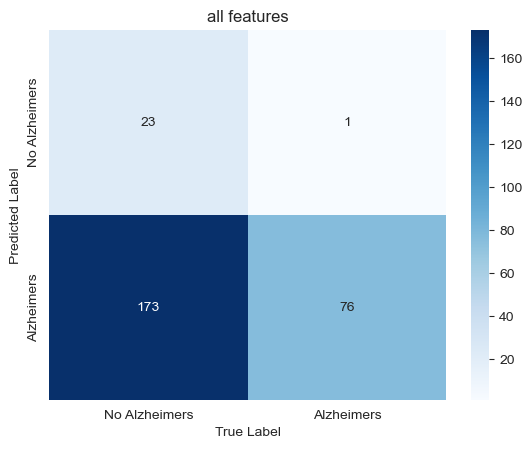

In [94]:
## Confusion matrix
sns.heatmap(confusion_matrix(preds_8,df_test.Diagnosis), annot=True, fmt="d", cmap="Blues", xticklabels=['No Alzheimers', 'Alzheimers'], yticklabels=['No Alzheimers', 'Alzheimers'])
plt.gca().set_title('all features')
plt.ylabel("Predicted Label")
plt.xlabel("True Label")
plt.show()

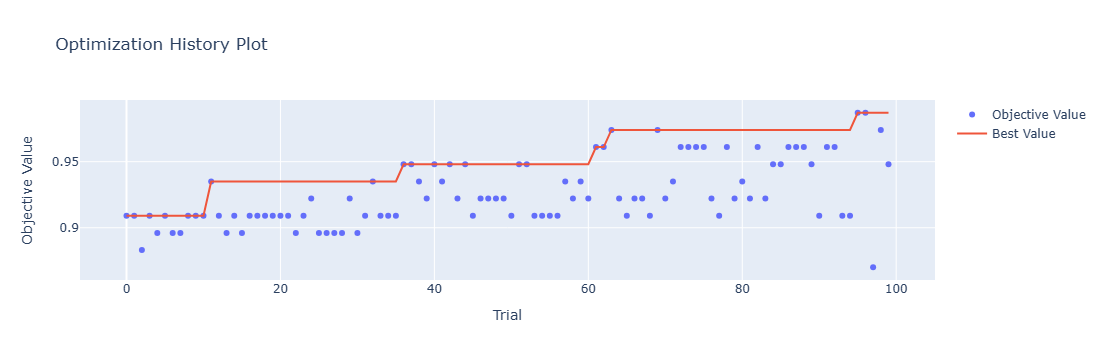

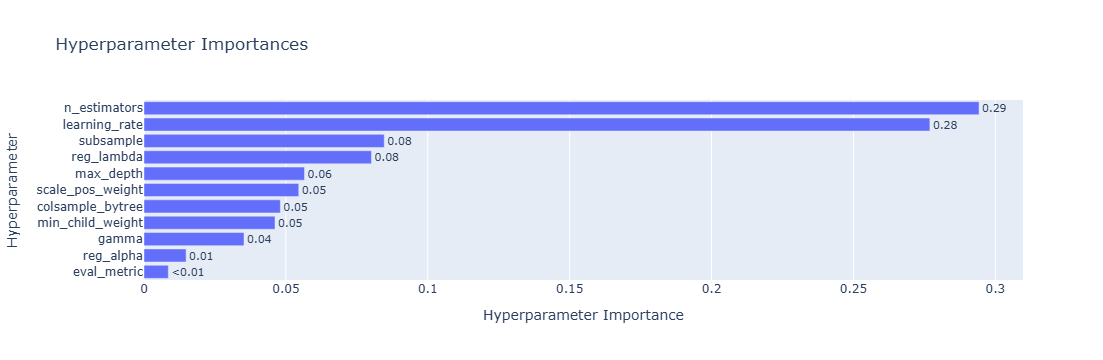

In [96]:
optuna.visualization.plot_optimization_history(study_8).show()
optuna.visualization.plot_param_importances(study_8).show()

## Summary of **XGBoost** hyperparameter tuning

In [98]:
## Table of the metrics for each tuned model
xgb_metrics_df = pd.DataFrame({'model_5': metrics_5 , 'model_6': metrics_6, 'model_7': metrics_7, 'model_8': metrics_8})
xgb_metrics_df.index = ['Accuracy Score', 'Precision Score' , 'Recall Score', 'F1 Score']
xgb_metrics_df

,model_5,model_6,model_7,model_8
Accuracy Score,0.956044,0.959707,0.956044,0.362637
Precision Score,0.896104,0.896104,0.896104,0.987013
Recall Score,0.945205,0.958333,0.945205,0.305221
F1 Score,0.920000,0.926174,0.920000,0.466258


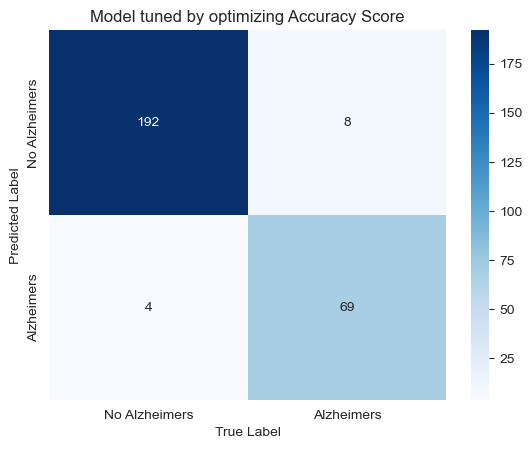

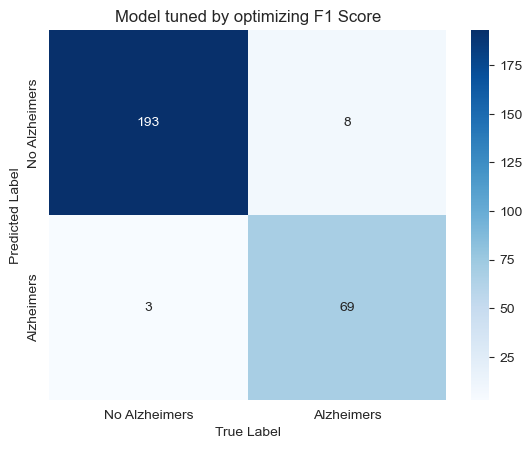

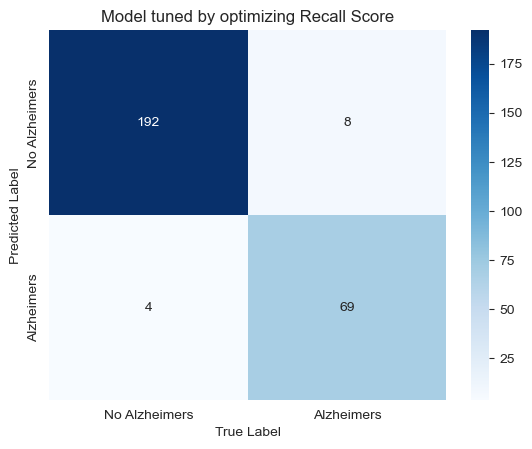

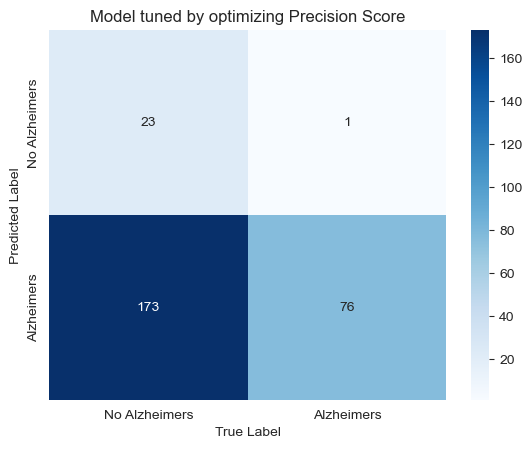

In [100]:
## Confusion matrices for each model
metric_labels = ['Accuracy Score', 'F1 Score' , 'Recall Score', 'Precision Score']
preds = [preds_5, preds_6, preds_7, preds_8]
for i in range(len(preds)):
    sns.heatmap(confusion_matrix(preds[i],df_test.Diagnosis), annot=True, fmt="d", cmap="Blues", xticklabels=['No Alzheimers', 'Alzheimers'], yticklabels=['No Alzheimers', 'Alzheimers'])
    plt.gca().set_title('Model tuned by optimizing '+ metric_labels[i])
    plt.ylabel("Predicted Label")
    plt.xlabel("True Label")
    plt.show()
    

# Conclusion

We can compare the performance of tuned **AdaBoost** vs tuned **XGBoost** models:

In [102]:
pd.concat([ada_metrics_df, xgb_metrics_df],axis = 1)

,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8
Accuracy Score,0.959707,0.959707,0.952381,0.956044,0.956044,0.959707,0.956044,0.362637
Precision Score,0.896104,0.896104,0.857143,0.883117,0.896104,0.896104,0.896104,0.987013
Recall Score,0.958333,0.958333,0.970588,0.957746,0.945205,0.958333,0.945205,0.305221
F1 Score,0.926174,0.926174,0.910345,0.918919,0.920000,0.926174,0.920000,0.466258


It seems that `model_1`, `model_2`, and `model_6` are the best-performing models overall. Here, we record the model hyperparameters for future reference. Note that running the script over and over might give different results. This is why we record the hyperparameters manually here rather than addressing `study_i.best_params` dictionary. 

In [3]:
## model_1 params
model_1_tree_params = {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 8}
model_1_ada_params = {'n_estimators': 155, 'learning_rate': 0.10565064269531074, 'algorithm': 'SAMME'}

## model_2 params
model_2_tree_params = {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 18}
model_2_ada_params = {'n_estimators': 167, 'learning_rate': 0.10697049944271753, 'algorithm': 'SAMME'}

## model_6 params
model_6_params = {'n_estimators': 342, 'learning_rate': 0.2936557853809352, 'max_depth': 4, 'min_child_weight': 2, 'gamma': 3, 'subsample': 0.9505333790576483, 'colsample_bytree': 0.6024713590870578, 'reg_alpha': 0.22059934204998982, 'reg_lambda': 0.8737784998045829, 'scale_pos_weight': 1, 'eval_metric': 'error'}

